In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
%cd ..
from src.MapData import MapData, min_max_dist, triangle_corr, get_triangular_kernel
from src.LineFinder import LineFinder
from src.plotting_functions import plot_embedding, plot_single_variable_map

from joblib import dump
from time import time
import re

d:\Projects


In [57]:
file_name = 'P44B_815x373'
# file_name = '2022_03_22_P56B_307x532'

parent_dir_name = re.search(
    'P[0-9]{2}B{0,1}',
    file_name
).group(0)

print(file_name)
print(parent_dir_name)

file_path = Path(f'./data/Rakoviny/{parent_dir_name}/{file_name}.libsdata')

P44B_815x373
P44B


In [58]:
print(file_path)
map_data = MapData(    
    file_path,
    overwrite=False
)
map_data.get_metadata()
map_data.load_wavelenths()
map_data.load_all_data('preprocessed')

map_data.trim_spectra(64)
map_data.get_map_dimensions()
map_data.estimate_systemic_noise()
map_data.get_baseline(
    min_window_size=50,
    smooth_window_size=100
)
map_data.baseline_correct()
map_data.upsample_spectra()
if map_data.systemic_noise_spectrum is not None:
    map_data.denoise_spectra(
        file_name_supplement='preprocessed',
        threshold=np.std(map_data.systemic_noise_spectrum),
        level=9
    )

maxima_spectrum = map_data.spectra.max(axis=0)

print('finding lines')
line_finder = LineFinder(
    maxima_spectrum,
    map_data.wvl,
    name='maxima'
)
line_finder.find_lines()
line_finder.load_nist_tables(
    Path('D:/OneDrive - Vysoké učení technické v Brně/projects/marsData/inventory/nistTables')
)
line_finder.find_peaks_in_reference(
    maxima_spectrum,
    scale=False,
    show_cond=False
)

map_data.set_emission_line_parameters(
    line_finder.peaks[1].get('left_bases'),
    line_finder.peaks[1].get('right_bases'),
    line_centers=line_finder.peaks[0]
)
map_data.set_emisssion_line_functions(
    intensity_funcs=[np.max,np.sum,min_max_dist,triangle_corr]
)
print('integrating emission line intensities')
map_data.get_emission_line_intensities()

data\Rakoviny\P44B\P44B_815x373.libsdata
loading metadata
loading wavelengths
getting map dimensions
finding lines
creating base plot
integrating emission line intensities
loading emission line intensities
converting line intensities to arrays


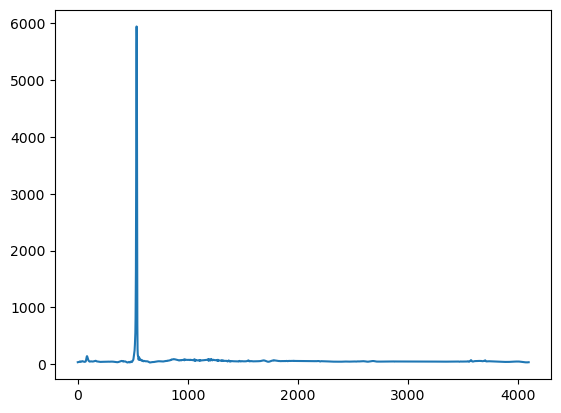

In [59]:
plt.plot(map_data.spectra[0,:])

In [60]:
line_finder.hist_bins

array([   75.4,   138.4,   201.2, ..., 62912. , 62976. , 63040. ],
      dtype=float16)

In [61]:
line_finder.plot_found_lines()

In [62]:
def process(
    model,
    model_params: dict,
    data
):
    save_dir = Path(f'./temp/{map_data.file_path.parent.name}/')
    if not save_dir.exists():
        print('creating results directory')
        save_dir.mkdir()

    model_id='{}_from_{}_{}'.format(
        model_params['model_type'].lower(),
        model_params['data_type'],
        model_params['model_tag']
    )
    print(f"{model_params['data_type']} - embedding")
    embeddings = model.fit_transform(data)
    ### plotting
    fig = plot_embedding(
        embeddings,
        # explained_variances=model.explained_variance_ratio_.copy(),
        # colors=predicted_labels[clustering_method],
        marker_size=8,
        return_figure=True
    )
    fig.suptitle(
        f"{model_params['model_type']} {LATENT_SPACE_DIM} comp. from {model_params['data_type']}"
    )
    fig.patch.set_alpha(0)
    fig.tight_layout()
    fig.savefig(
        save_dir.joinpath(f'latent_space_{model_id}.png'),
        transparent=True
    )
    ### saving model and embeddings
    print(f"{model_params['data_type']} - saving model")
    # dump(
    #     model,
    #     f'./temp/{model_id}.joblib'
    # )
    print(f"{model_params['data_type']} - saving embeddings")
    np.save(
        file=save_dir.joinpath(f'embeddings_{model_id}.npy'),
        arr=embeddings
    )

    plt.close()

    with open(save_dir.joinpath(f"model_params_{model_params['model_tag']}.json"), 'w') as f:
        json.dump(model_params, f)

    return None

In [63]:
# Embeddings
LATENT_SPACE_DIM = 3

model_params = dict(
    model_type=None,
    model_tag=None,
    file_name=file_name,
    data_type=None,
    n_components=LATENT_SPACE_DIM,
    random_state=97481
)

## PCA from emission lines ----------------------------------------------
model_params['model_type'] = 'PCA'

for data_type in ['line','spectra']:
    model_params['model_tag'] = int(time())
    model_params['data_type'] = data_type

    process(
        model=PCA(LATENT_SPACE_DIM),
        model_params=model_params,
        data=pd.DataFrame.from_dict(
            {(i,j): map_data.line_intensities[i][j] 
            for i in map_data.line_intensities 
            for j in map_data.line_intensities[i]},
            orient='columns'
        ).fillna(0) if data_type == 'line' else pd.DataFrame(map_data.spectra)
    )
## tSNE from emission lines ----------------------------------------------
model_params['model_type'] = 'tSNE'
model_params['learning_rate'] = 'auto'
model_params['n_iter'] = 100

for data_type in ['line','spectra']:
    model_params['data_type'] = data_type
    for metric in ['cosine','euclidean']:
        for perp in [5,10,20,30,50]:
            model_params['model_tag'] = int(time())
            model_params['perplexity'] = perp
            model_params['metric'] = metric

            process(
                model=TSNE(
                    n_components=LATENT_SPACE_DIM,
                    perplexity=model_params['perplexity'],
                    learning_rate=model_params['learning_rate'],
                    random_state=model_params['random_state'],
                    metric=model_params['metric']
                ),
                model_params=model_params,
                data=pd.DataFrame.from_dict(
                    {(i,j): map_data.line_intensities[i][j]
                    for i in map_data.line_intensities
                    for j in map_data.line_intensities[i]},
                    orient='columns'
                ).fillna(0) if data_type == 'line' else pd.DataFrame(map_data.spectra)
            )
# ## UMAP from emission lines ----------------------------------------------
model_params['model_type'] = 'UMAP'
model_params['min_dist'] = 0.1
model_params['output_metric'] = 'euclidean'
model_params['n_epochs'] = 200
model_params['learning_rate'] = 1

for data_type in ['line','spectra']:
    model_params['data_type'] = data_type
    for metric in ['cosine','euclidean']:
        for nn in [5,15,30,50]:
            model_params['model_tag'] = int(time())
            model_params['n_neighbors'] = nn
            model_params['metric'] = metric

            process(
                model=UMAP(
                    n_components=LATENT_SPACE_DIM,
                    n_neighbors=nn,
                    metric=metric,
                    min_dist=model_params['min_dist'],
                    output_metric=model_params['output_metric'],
                    n_epochs=model_params['n_epochs'],
                    learning_rate=model_params['learning_rate'],
                    random_state=model_params['random_state'],
                ),
                model_params=model_params,
                data=pd.DataFrame.from_dict(
                    {(i,j): map_data.line_intensities[i][j]
                    for i in map_data.line_intensities
                    for j in map_data.line_intensities[i]},
                    orient='columns'
                ).fillna(0) if data_type == 'line' else pd.DataFrame(map_data.spectra)
            )

creating results directory
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
line - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



line - saving model
line - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
spectra - embedding


d:\Projects\segmentation\src\plotting_functions.py:139: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



spectra - saving model
spectra - saving embeddings
